#Sentence Classification using BERT

In [1]:
import tensorflow as tf

# Checking for the GPU
device_name = tf.test.gpu_device_name()
print(device_name)


/device:GPU:0


In [2]:
import torch

device = torch.device("cuda")



In [3]:
!pip install transformers

     |████████████████████████████████| 778kB 6.2MB/s 
     |████████████████████████████████| 890kB 17.5MB/s 
     |████████████████████████████████| 1.1MB 33.1MB/s 
     |████████████████████████████████| 3.0MB 15.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=8aaa7e1fbdf1cfdca5d7cbe9838b8b6b7821a21f29f8fdab7e64fc04e7fa6345
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


We are using [The Corpus of Linguistic Acceptability (CoLA)](https://nyu-mll.github.io/CoLA/) dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. It was first published in May of 2018, and is one of the tests included in the "GLUE Benchmark" on which models like BERT are competing.


In [4]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=57410eb6707a58ef29c9e04f4062f3867ea0f14d32cf0065baa0b97f2f9286fb
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


The original dataset is available on: https://nyu-mll.github.io/CoLA/

In [5]:
import wget
import os



# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

wget.download(url, './cola_public_1.1.zip')

'./cola_public_1.1.zip'

In [6]:
# Unzipping the dataset
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [7]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
6960,m_02,1,NaN,The Minister has arrived.
7967,ad03,1,NaN,For Aphrodite to appear to be happy would be i...
328,bc01,1,NaN,"No books survived the fire, did they?"
2160,l-93,1,NaN,Terry touched Bill on the shoulder.
2191,l-93,1,NaN,The statue stood on the pedestal.
8410,ad03,1,NaN,I expected there to be a problem.
1628,r-67,1,NaN,How brave they must believe that you are!
6691,m_02,1,NaN,Emma slighted Miss Bates.
5364,b_73,1,NaN,Enough is going on to keep them confused.
2307,l-93,1,NaN,Linda taped the label to the cover.


In [8]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
1659,"Fluffy is sick, which I slapped a boy who woul...",0
4332,Under the bed wants to be a fun place to hide.,0
3733,"The book, including all the chapters in the fi...",0
6407,"Every student in Mary's class, whoever they we...",0
6568,Where and when did Bill put the book?,0


In [9]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

In [10]:
from transformers import BertTokenizer

# Load the BERT tokenizer.

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [11]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [12]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: [101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]


In [13]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  47


In [14]:
# We will use some utility function from tensorflow(Tensorflow was my first crush)
from keras.preprocessing.sequence import pad_sequences


MAX_LEN = 64

#Padding the input to the max length that is 64
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")



In [15]:
# Creating the attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [16]:
# We will call the train_test_split() function from sklearn
from sklearn.model_selection import train_test_split


train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Performing same steps on the attention masks
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [17]:
#Converting the input data to the tensor , which can be feeded to the model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Creating the DataLoader which will help us to load data into the GPU/CPU
batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [19]:
#Loading the pre-trained BERT model from huggingface library

from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,   
    output_attentions = False, 
    output_hidden_states = False, )

# Teeling the model to run on GPU
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [20]:
# AdamW is an optimizer which is a Adam Optimzier with weight-decay-fix
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )


In [21]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
scheduler

Define a helper function for calculating accuracy.

In [22]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [23]:
#Creating the helper function to have a watch on elapsed time

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [24]:
#Let's start the training process

import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:27.
  Batch    80  of    241.    Elapsed: 0:00:54.
  Batch   120  of    241.    Elapsed: 0:01:21.
  Batch   160  of    241.    Elapsed: 0:01:48.
  Batch   200  of    241.    Elapsed: 0:02:15.
  Batch   240  of    241.    Elapsed: 0:02:42.

  Average training loss: 0.50
  Training epcoh took: 0:02:43

Running Validation...
  Accuracy: 0.77
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:27.
  Batch    80  of    241.    Elapsed: 0:00:54.
  Batch   120  of    241.    Elapsed: 0:01:21.
  Batch   160  of    241.    Elapsed: 0:01:48.
  Batch   200  of    241.    Elapsed: 0:02:15.
  Batch   240  of    241.    Elapsed: 0:02:42.

  Average training loss: 0.32
  Training epcoh took: 0:02:42

Running Validation...
  Accuracy: 0.82
  Validation took: 0:00:06

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:27.
  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


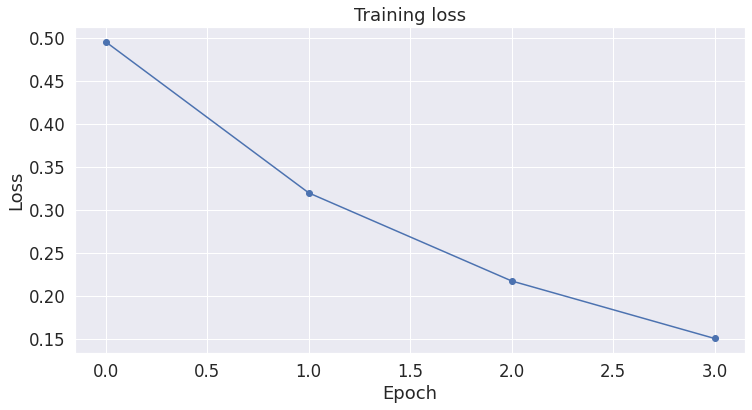

In [25]:
#Plotting the training loss vs number of epochs

import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [26]:
print(loss_values) #Having a view of stored loss values in the list

[0.4956092043041688, 0.3199369729925488, 0.2174745194335696, 0.15056898273311214]


In [27]:
#Loading the test data and applying the same preprocessing techniques which we performed on the train data
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



In [28]:
#Evaluating our model on the test set

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)



Predicting labels for 516 test sentences...


We will use Matthews Correlation Coefficient(MCC) to evaluate our model. 
MCC is used in many areas of Natural Language Processing. Also, it's a great metric to be used for imbalanced dataset

Link: https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a


In [29]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [30]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [31]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.555


We fine-tuned BERT without going into much deeper operations such as hyperparameter tuning. MCC of 0.555 is an okayish score for such tasks and keeping in mind that we didn't trained our model on complete dataset, and very few epochs.